In [1]:
import pandas as pd
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from scipy import stats
from collections import defaultdict
import csv
import seaborn as sns

In [2]:
players = pd.read_csv('./data/players.csv')
games = pd.read_csv('./data/games.csv')
plays = pd.read_csv('./data/plays.csv')

In [3]:
def mapIdToName(id):
    return players[players['nflId'] == id].iloc[0].displayName

In [4]:
def getClosest(players, football):
    distances = []
    for index, row in players.iterrows():
        distance = np.linalg.norm(np.subtract([football.x.values[0], football.y.values[0]], [row.x, row.y]))
        distances.append((row.nflId, distance))
    closest = sorted(distances, key= lambda t: t[1])[0][0]
    return closest

In [5]:
tackle_acc = defaultdict(list)
total_tackles = defaultdict(int)

In [6]:
for week_num in range(1, 18):
    print(week_num)
    g_week = games[games['week'] == week_num]
    week_str = './data/week' + str(week_num) + '.csv'
    current_week_data = pd.read_csv(week_str)
    
    for _, g_row in g_week.iterrows():
        GAMEID = g_row.gameId
        cwg_data = current_week_data[current_week_data['gameId'] == GAMEID]
        pg = plays[plays['gameId'] == GAMEID]
        
        for PLAY in pg.playId:
            curr_play_data = cwg_data[cwg_data['playId'] == PLAY]
            try:
                OFFENSIVE_TEAM = curr_play_data[curr_play_data['position'] == 'QB'].team.values[0]
                DEFENSIVE_TEAM = ('home' if OFFENSIVE_TEAM == 'away' else 'away')
            except:
                continue

            play_events = pd.unique(curr_play_data.event)
            if 'first_contact' in play_events:

                first_contact_data = curr_play_data[curr_play_data['event'] == 'first_contact']
                football1 = first_contact_data[first_contact_data['team'] == 'football']
                defensive_players = first_contact_data[first_contact_data['team'] == DEFENSIVE_TEAM]
                try:
                    closest1 = getClosest(defensive_players, football1)
                except:
                    continue

                if 'tackle' in play_events:

                    tackle_data = curr_play_data[curr_play_data['event'] == 'tackle']
                    football2 = tackle_data[tackle_data['team'] == 'football']
                    defensive_players = tackle_data[tackle_data['team'] == DEFENSIVE_TEAM]
                    closest2 = getClosest(defensive_players, football2)

                    tackle_acc[closest1].append(1 if closest1 == closest2 else 0)
                    total_tackles[closest2] += 1

                elif 'out_of_bounds' in play_events:

                    out_of_bounds_data = curr_play_data[curr_play_data['event'] == 'out_of_bounds']
                    football2 = out_of_bounds_data[out_of_bounds_data['team'] == 'football']
                    defensive_players = out_of_bounds_data[out_of_bounds_data['team'] == DEFENSIVE_TEAM]
                    closest2 = getClosest(defensive_players, football2)

                    dif = np.abs(football2.x.values[0] - football1.x.values[0])
                    if closest1 == closest2 and dif < 3:
                        tackle_acc[closest1].append(1)
                        total_tackles[closest1] += 1
                    else:
                        tackle_acc[closest1].append(0)

                else:
                    continue
                    



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [7]:
tackle_acc_r = {k: np.sum(v) / len(v) for k,v in tackle_acc.items() if len(v) > 17}
readable_dict = {mapIdToName(k): v for k,v in tackle_acc_r.items()}
sorted(readable_dict.items(), key=lambda t: t[1], reverse=True)[:50]

[('Jaire Alexander', 0.8571428571428571),
 ('Chris Harris', 0.8518518518518519),
 ('Darius Slay', 0.8260869565217391),
 ('Zach Brown', 0.7916666666666666),
 ('Bradley McDougald', 0.7619047619047619),
 ('Myles Jack', 0.75),
 ('Vonn Bell', 0.75),
 ('Rasul Douglas', 0.75),
 ('Justin Simmons', 0.7428571428571429),
 ('Antoine Bethea', 0.7419354838709677),
 ('B.W. Webb', 0.7368421052631579),
 ('Marcus Peters', 0.7307692307692307),
 ('Reshad Jones', 0.72),
 ('D.J. Hayden', 0.72),
 ('Robert Alford', 0.7142857142857143),
 ('Jalen Ramsey', 0.7142857142857143),
 ('Trumaine Johnson', 0.7096774193548387),
 ('Mike Hilton', 0.7083333333333334),
 ('Leighton Vander Esch', 0.7083333333333334),
 ('Cory Littleton', 0.7037037037037037),
 ('Darron Lee', 0.6956521739130435),
 ('Avery Williamson', 0.6923076923076923),
 ('Roquan Smith', 0.6875),
 ('Demario Davis', 0.6857142857142857),
 ("De'Vondre Campbell", 0.6842105263157895),
 ('Anthony Walker', 0.6842105263157895),
 ('Eric Weddle', 0.6842105263157895),
 ('

In [8]:
with open('tackle_acc.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['nflId', 'score'])
    for key, value in tackle_acc_r.items():
       writer.writerow([key, value])

In [27]:
MAX_TACKLES = max(total_tackles.values())
tackle_acc_t = {k: (np.sum(v) / len(v)) * (total_tackles.get(k, 0) / MAX_TACKLES) for k,v in tackle_acc.items()}
readable_dict = {mapIdToName(k): v for k,v in tackle_acc_t.items()}
best_tacklers = sorted(readable_dict.items(), key=lambda t: t[1], reverse=True)[:15]

In [10]:
with open('tackle_acc_and_totals.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    writer.writerow(['nflId', 'score'])
    for key, value in tackle_acc_t.items():
       writer.writerow([key, value])

In [28]:
bt = {}
for t in best_tacklers:
    bt[t[0]] = t[1]
df = pd.DataFrame.from_dict(bt, orient='index')
df.reset_index(level=0, inplace=True)
df = df.rename(columns={"index": "name", 0: "score"})

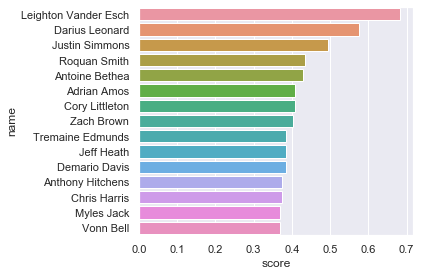

In [34]:
sns.set_theme(style='darkgrid')
ax = sns.barplot(x='score', y='name', data=df)
ax.figure.tight_layout()
ax.figure.savefig('tackle_graph.png')